In [1]:
''' read & compute SD alongtrack timeseries of GFS/RTOFS & SD's wind power and acc energy to NI motions 
SD: use tau that is adjusted to 10m by a simple power law method '''
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import datetime
import os
import sys
from scipy import stats
from itertools import combinations
from scipy.stats import pearsonr
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
# adding to the system path
sys.path.insert(0, path_nhchi)
from mystats import bandpass

In [2]:
''' SD data info - (not the entire alongtrack record. period specified in the filenames) '''
year = '2023'
platfs_num = ['1036','1041','1069'] #['1031','1036','1040','1041','1042','1045','1057','1064','1065','1068','1069','1083']
tlim_plot = [[datetime.datetime(int(year),9,7), datetime.datetime(int(year),9,19)],\
             [datetime.datetime(int(year),9,6), datetime.datetime(int(year),9,18)],\
                [datetime.datetime(int(year),9,3), datetime.datetime(int(year),9,15)]]
nday_plot = [(item[1]-item[0]).days for item in tlim_plot]
print(tlim_plot)
print(nday_plot,'days')
tticks = [[item[0]+datetime.timedelta(days=j) for j in range(nday_plot[i])] for i,item in enumerate(tlim_plot)]
tticks_label = [[item[i].strftime('%m/%d') for i in range(len(item))] for item in tticks]
print(tticks)
print(tticks_label)
''' '''
path_SD = os.path.expanduser('~/Documents/projects/sd-ni-wp/HU_LEE/')
filenames_SD_all = np.sort( os.listdir(path_SD) )
filenames_SD = np.array([])
for file in filenames_SD_all:
    if ('timeseries' in file) & ('.txt' in file) & (year in file):
        filenames_SD = np.append(filenames_SD, file)
print(len(filenames_SD), filenames_SD)

[[datetime.datetime(2023, 9, 7, 0, 0), datetime.datetime(2023, 9, 19, 0, 0)], [datetime.datetime(2023, 9, 6, 0, 0), datetime.datetime(2023, 9, 18, 0, 0)], [datetime.datetime(2023, 9, 3, 0, 0), datetime.datetime(2023, 9, 15, 0, 0)]]
[12, 12, 12] days
[[datetime.datetime(2023, 9, 7, 0, 0), datetime.datetime(2023, 9, 8, 0, 0), datetime.datetime(2023, 9, 9, 0, 0), datetime.datetime(2023, 9, 10, 0, 0), datetime.datetime(2023, 9, 11, 0, 0), datetime.datetime(2023, 9, 12, 0, 0), datetime.datetime(2023, 9, 13, 0, 0), datetime.datetime(2023, 9, 14, 0, 0), datetime.datetime(2023, 9, 15, 0, 0), datetime.datetime(2023, 9, 16, 0, 0), datetime.datetime(2023, 9, 17, 0, 0), datetime.datetime(2023, 9, 18, 0, 0)], [datetime.datetime(2023, 9, 6, 0, 0), datetime.datetime(2023, 9, 7, 0, 0), datetime.datetime(2023, 9, 8, 0, 0), datetime.datetime(2023, 9, 9, 0, 0), datetime.datetime(2023, 9, 10, 0, 0), datetime.datetime(2023, 9, 11, 0, 0), datetime.datetime(2023, 9, 12, 0, 0), datetime.datetime(2023, 9, 13, 

In [3]:
''' along track data info with GFS flux data '''
path_GFS = os.path.expanduser('~/Documents/projects/sd-ni-wp/SD_windstress/compare_SD_model/data_timeseries_match_SD_GFS/')
filenames_GFS_all = np.sort( os.listdir(path_GFS) )
filenames_GFS = np.array([])
for file in filenames_GFS_all:
    if ('u10' in file) & ('.txt' in file) & (year in file) & (file[-12:-8] in platfs_num):
        filenames_GFS = np.append(filenames_GFS, file)
print(len(filenames_GFS), filenames_GFS)

3 ['timeseries_wnd_u10m_match_2023-SD1036_GFS.txt'
 'timeseries_wnd_u10m_match_2023-SD1041_GFS.txt'
 'timeseries_wnd_u10m_match_2023-SD1069_GFS.txt']


In [4]:
''' load GFS flux & RTOFS bandpass current data '''
path_GFS_bp = os.path.expanduser('~/Documents/projects/sd-ni-wp/check_model/compute_wp/')
filename_GFS_bp = 'GFS-momFlux(RTOFS-grids)_RTOFS-NIUV(0.80f-1.20f)_20230904-20230921_10.0N-45.0N_-80.0--40.0.nc'
# print( os.listdir(path_GFS_bp) )
ds_GFS_bp = nc.Dataset(path_GFS_bp+filename_GFS_bp)
print(ds_GFS_bp)
time_GFS_flux = ds_GFS_bp['time'][:]
timestamp_GFS_flux = np.array([(datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=item)).timestamp() \
                               for item in time_GFS_flux])
lon_GFS_flux = ds_GFS_bp['longitude'][:]
lat_GFS_flux = ds_GFS_bp['latitude'][:]
UFLX_AVE = ds_GFS_bp['UFLX_AVE'][:] # positive towards atmosphere
VFLX_AVE = ds_GFS_bp['VFLX_AVE'][:]
u_bp = ds_GFS_bp['u_bp'][:] # m/s
v_bp = ds_GFS_bp['v_bp'][:]
print('lon shape, values',lon_GFS_flux.shape,lon_GFS_flux[0:2],lon_GFS_flux[-1])
print('lat shape, values',lat_GFS_flux.shape,lat_GFS_flux[0:2],lat_GFS_flux[-1])
print(UFLX_AVE.shape, u_bp.shape)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: GFS momentum flux on RTOFS spatial grids & RTOFS bandpass (NI:0.80f-1.20f) surface currents 
for 20230904-20230921, 10.0N-45.0N_-80.0--40.0
    subtitle: It took ~370 minutes to interpolate GFS momentum flux to RTOFS spatial grids.
    dimensions(sizes): time(432), longitude(500), latitude(506)
    variables(dimensions): float64 time(time), float64 longitude(longitude), float64 latitude(latitude), float64 UFLX_AVE(time, latitude, longitude), float64 VFLX_AVE(time, latitude, longitude), float64 u_bp(time, latitude, longitude), float64 v_bp(time, latitude, longitude)
    groups: 
lon shape, values (500,) [-80.         -79.92004395] -40.0799560546875
lat shape, values (506,) [10.02840137 10.10716915] 44.986572265625
(432, 506, 500) (432, 506, 500)


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: Merged files for RTOFS surface.now. data between 20230905 and 20230922
    subtitle: Only selected variables for are merged here. The data is hourly with 0.08 deg horizontal resolution.
    dimensions(sizes): time(432), depth(1), longitude(901), latitude(551)
    variables(dimensions): float64 depth(depth), float64 time(time), float64 LONGITUDE(latitude, longitude), float64 LATITUDE(latitude, longitude), float64 U_VELOCITY(time, depth, latitude, longitude), float64 V_VELOCITY(time, depth, latitude, longitude), float64 MIXED_LAYER_THICKNESS(time, latitude, longitude)
    groups: 
time shape, values (432,) 2023-09-04 00:00:00 2023-09-21 23:00:00
(551, 901)
lon shape, values (551, 901) [-101.92004395 -101.83996582] -29.9200439453125
lat shape, values (551, 901) [7.57781076 7.65710497] 45.77324676513672
(432, 1, 551, 901)


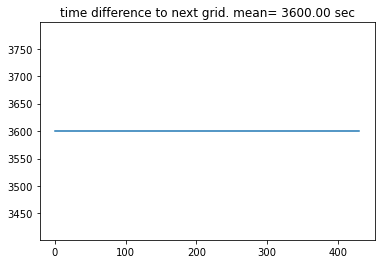

In [5]:
''' load GFS bandpass data '''
path_RTOFS = os.path.expanduser('~/Documents/projects/sd-ni-wp/check_model/check_RTOFS/')
filename_RTOFS = 'RTOFS.merge.surface.now.20230905-20230922.nc'
ds_RTOFS = nc.Dataset(path_RTOFS+filename_RTOFS)
print(ds_RTOFS)
time_RTOFS = ds_RTOFS['time'][:]
timestamp_RTOFS = np.array([(datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=item)).timestamp() \
                            for item in time_RTOFS])
print('time shape, values',timestamp_RTOFS.shape,datetime.datetime.fromtimestamp(timestamp_RTOFS[0]),datetime.datetime.fromtimestamp(timestamp_RTOFS[-1]))
plt.clf()
plt.plot(np.diff(timestamp_RTOFS))
plt.title('time difference to next grid. mean= {:.2f} sec'.format(np.nanmean(np.diff(timestamp_RTOFS))))
lon_RTOFS = ds_RTOFS['LONGITUDE'][:]
lon_RTOFS[lon_RTOFS> 180] = lon_RTOFS[lon_RTOFS> 180]-360
lat_RTOFS = ds_RTOFS['LATITUDE'][:]
print(lon_RTOFS.shape)
print('lon shape, values',lon_RTOFS.shape,lon_RTOFS[0,0:2],lon_RTOFS[0,-1])
print('lat shape, values',lat_RTOFS.shape,lat_RTOFS[0:2,0],lat_RTOFS[-1,0])
u_RTOFS = ds_RTOFS['U_VELOCITY'][:]
v_RTOFS = ds_RTOFS['V_VELOCITY'][:]
print(u_RTOFS.shape)

Look at 2 files: timeseries_wnd_u10m_match_2023-SD1036_GFS.txt timeseries_wnd_cur_bp(0.80f-1.20f)_wp_energy_2023-SD1036_20230907-0919_600.0-sec-grid.txt
GFS shape, time: (2034, 11) [datetime.datetime(2023, 8, 1, 1, 0) datetime.datetime(2023, 8, 1, 2, 0)] ... 2023-10-26 18:00:00
SD time: (1728, 15) [datetime.datetime(2023, 9, 7, 0, 0) datetime.datetime(2023, 9, 7, 0, 10)] ... 2023-09-18 23:50:00
dtime_common shape, time: (288,) [datetime.datetime(2023, 9, 7, 0, 0) datetime.datetime(2023, 9, 7, 1, 0)] 2023-09-18 23:00:00
0 0
RTOFS time res= 3600.00sec, mean lat=25.52
=== start priting stats alongtrack 1036===
max(tau_GFS) = 3.30E+00
max(cur_mag_bp_GFS) = 5.58E-01
max(cur_mag_bp_RTOFS) = 5.21E-01
max(wp_SD_onGFS_grid) = 7.27E-01
max(wp_GFS) = 1.33E+00
max(wp_model_alongtrack) = 1.07E+00
max(energy_SD_onGFS_grid) = 1.99E+04
energy_SD_onGFS_grid plateau at 1.65E+04
max(energy_GFS) = 4.58E+04
energy_GFS plateau at 4.18E+04
max(energy_model_alongtrack_bp) = 3.46E+04
energy_model_alongtrack_bp

<Figure size 432x288 with 0 Axes>

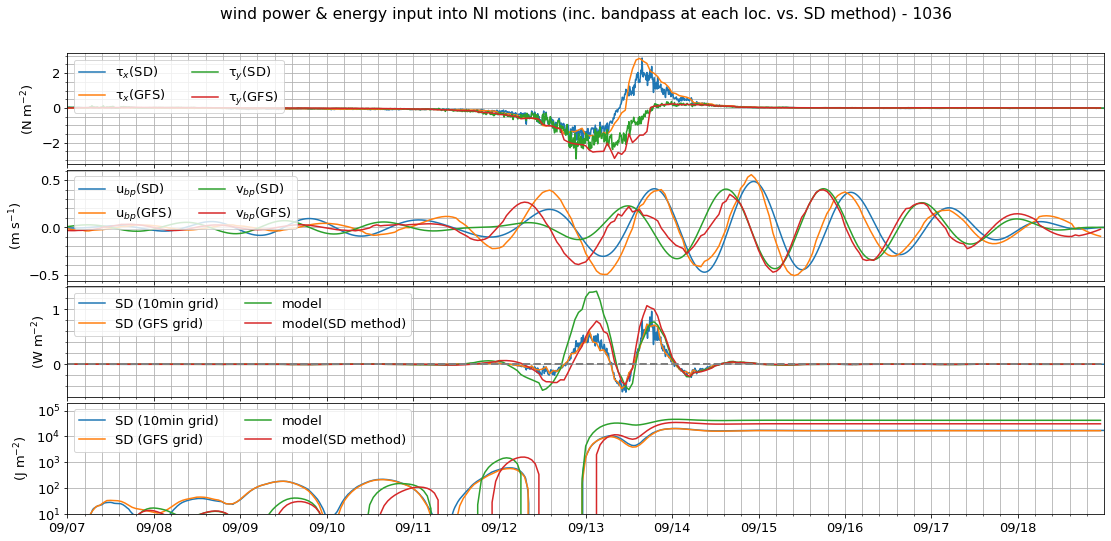

In [6]:
''' compute & compare/ print results from SD & model '''
# for f, platf in enumerate( platfs_num ):
for f in range( 0,len(platfs_num) ):
    platf = platfs_num[f]
    dataGFS = np.genfromtxt( path_GFS+filenames_GFS[f], skip_header=True, delimiter=' ')
    dataSD = np.genfromtxt( path_SD+filenames_SD[f], skip_header=True, delimiter=' ')
    print('Look at 2 files:',filenames_GFS[f], filenames_SD[f])
    ''' GFS time '''
    dtimeGFS = np.array([datetime.datetime.fromtimestamp(item) for item in dataGFS[:,0]])
    timestampGFS = dataGFS[:,0] #np.array([item.timestamp() for item in dtimeGFS])
    print('GFS shape, time:',dataGFS.shape, dtimeGFS[0:2],'...', dtimeGFS[-1])
    ''' SD time '''
    dtimeSD = np.array([datetime.datetime.fromtimestamp(item) for item in dataSD[:,0]])
    timestampSD = dataSD[:,0]#np.array([item.timestamp() for item in dtimeSD])
    print('SD time:',dataSD.shape ,dtimeSD[0:2],'...', dtimeSD[-1])
    ''' keep the array within tlim_plot[f] range first '''
    itkeep = np.where( (dataGFS[:,0]>= tlim_plot[f][0].timestamp()) & (dataGFS[:,0]< tlim_plot[f][1].timestamp()) )[0]
    dataGFS = dataGFS[itkeep,:]
    dtimeGFS = dtimeGFS[itkeep]
    timestampGFS = timestampGFS[itkeep]
    itkeep = np.where( (dataSD[:,0]>= tlim_plot[f][0].timestamp()) & (dataSD[:,0]< tlim_plot[f][1].timestamp()) )[0]
    dataSD = dataSD[itkeep,:]
    dtimeSD = dtimeSD[itkeep]
    timestampSD = timestampSD[itkeep]
    ''' find match data points: GFS is hourly data & have them within tlim_plot[f] '''
    dtime_common, icommGFS, icommSD = np.intersect1d( dtimeGFS, dtimeSD, assume_unique= True, return_indices= True )
    timestamp_common = np.array([item.timestamp() for item in dtime_common])
    print('dtime_common shape, time:',dtime_common.shape,dtime_common[0:2],dtime_common[-1])
    ''' get RTOFS absolute velocities '''
    uRTOFS = np.nan*np.ones( (len(timestamp_common),) )
    vRTOFS = uRTOFS.copy()
    ''' get bandpassed velocities from "GFS' flux & RTOFS' bandpass current" file: '''
    wp_GFS = np.nan*np.ones( (len(timestamp_common),) )
    energy_GFS = wp_GFS.copy()
    taux_GFS = wp_GFS.copy()
    tauy_GFS = wp_GFS.copy()
    u_bp_GFS = wp_GFS.copy() # this should be named as u_bp_RTOFS
    v_bp_GFS = wp_GFS.copy()
    energy_model_alongtrack_bp = wp_GFS.copy()
    for i in range( len(timestamp_common) ):
        ''' from RTOFS data file '''
        it = np.argmin( np.abs(timestamp_RTOFS- dataGFS[icommGFS[i],0]) )
        ilon = np.argmin( np.abs(lon_RTOFS[0,:]- dataGFS[icommGFS[i],1]) )
        ilat = np.argmin( np.abs(lat_RTOFS[:,0]- dataGFS[icommGFS[i],2]) )
        uRTOFS[i] = u_RTOFS[it,0,ilat,ilon]
        vRTOFS[i] = v_RTOFS[it,0,ilat,ilon]
        # print(i, it, ilat, ilon, u_RTOFS[it,0,ilat,ilon], v_RTOFS[it,0,ilat,ilon])
        ''' from flux & bp current data file '''
        it = np.argmin( np.abs(timestamp_GFS_flux- dataGFS[icommGFS[i],0]) )
        ilon = np.argmin( np.abs(lon_GFS_flux- dataGFS[icommGFS[i],1]) )
        ilat = np.argmin( np.abs(lat_GFS_flux- dataGFS[icommGFS[i],2]) )
        taux_GFS[i] = -UFLX_AVE[it,ilat,ilon]
        tauy_GFS[i] = -VFLX_AVE[it,ilat,ilon]
        u_bp_GFS[i] = u_bp[it,ilat,ilon] # m/s
        v_bp_GFS[i] = v_bp[it,ilat,ilon]
        wp_GFS[i] = taux_GFS[i]*u_bp_GFS[i] + tauy_GFS[i]*v_bp_GFS[i]
        # print(i, it, ilat, ilon, -UFLX_AVE[it,ilat,ilon], -VFLX_AVE[it,ilat,ilon])

    ''' check if there's NaN data '''
    print(np.sum(np.isnan(uRTOFS)), np.sum(np.isnan(vRTOFS)))
    ''' settings for computing bandpass velocity '''
    n_f = np.array([0.8,1.2])
    dsec_RTOFS = (time_RTOFS[1]-time_RTOFS[0])
    lat_mn = np.nanmean(dataSD[icommSD,2])
    print('RTOFS time res= {:.2f}sec, mean lat={:.2f}'.format(dsec_RTOFS, lat_mn))
    f_mn = 2*(2*np.pi/86400)*np.sin(lat_mn/180*np.pi) # 1/s
    f_bp = f_mn*n_f
    bp_sec = 2*np.pi/f_bp
    ''' compute bandpass velocity '''
    ucur_RTOFS_bp, _,_,_,_ = bandpass(uRTOFS, dsec_RTOFS, bp_sec[0], bp_sec[1],2)
    vcur_RTOFS_bp, _,_,_,_ = bandpass(vRTOFS, dsec_RTOFS, bp_sec[0], bp_sec[1],2)
    wp_model_alongtrack = taux_GFS*ucur_RTOFS_bp + tauy_GFS*vcur_RTOFS_bp
    # break
    ''' compute 2 sets of accumulated energy from SD: (1) on hourly grid (2) on 10-minute grid '''
    wp_SD_onGFS_grid = dataSD[icommSD,13]
    energy_SD_onGFS_grid = np.nan*np.ones( (len(timestamp_common),) )
    for i in range( len(timestamp_common) ):
        ''' SD '''
        iOK = ~np.isnan(wp_SD_onGFS_grid)
        y_clean = wp_SD_onGFS_grid[iOK]
        x_clean = timestamp_common[iOK]
        energy_SD_onGFS_grid[i] = np.trapz( y_clean[:i+1], x_clean[:i+1])
        ''' GFS '''
        iOK = ~np.isnan(wp_GFS)
        y_clean = wp_GFS[iOK]
        x_clean = timestamp_common[iOK]
        energy_GFS[i] = np.trapz( y_clean[:i+1], x_clean[:i+1])
        ''' use along track RTOFS current --> bandpass --> wp '''
        iOK = ~np.isnan(wp_model_alongtrack)
        y_clean = wp_model_alongtrack[iOK]
        x_clean = timestamp_common[iOK]
        energy_model_alongtrack_bp[i] = np.trapz( y_clean[:i+1], x_clean[:i+1])

    ''' plot GFS (from UFLX, VFLX) & SD's (2 temporal grid) wind power & accumulated energy results '''
    nrow = 4
    plt.clf()
    fig = plt.figure(figsize=(18,8))
    plt.rcParams.update({'font.size': 13})
    ''' wind stress '''
    plt.subplot(nrow,1,1)
    plt.plot(dtimeSD, dataSD[:,5], label='\u03C4$_x$(SD)')
    plt.plot(dtime_common, taux_GFS, label='\u03C4$_x$(GFS)')
    plt.plot(dtimeSD, dataSD[:,6], label='\u03C4$_y$(SD)')
    plt.plot(dtime_common, tauy_GFS, label='\u03C4$_y$(GFS)')
    plt.ylabel('(N m$^{-2}$)')
    ''' bandpass current '''
    plt.subplot(nrow,1,2)
    plt.plot(dtimeSD, 0.01*dataSD[:,9], label='u$_{bp}$(SD)')
    plt.plot(dtime_common, u_bp_GFS, label='u$_{bp}$(GFS)')
    plt.plot(dtimeSD, 0.01*dataSD[:,10], label='v$_{bp}$(SD)')
    plt.plot(dtime_common, v_bp_GFS, label='v$_{bp}$(GFS)')
    plt.ylabel('(m s$^{-1}$)')
    ''' wind power '''
    plt.subplot(nrow,1,3)
    plt.plot(dtimeSD, dataSD[:,13], label='SD (10min grid)')
    plt.plot(dtime_common, wp_SD_onGFS_grid, label='SD (GFS grid)')
    plt.plot(dtime_common, wp_GFS, label='model')
    plt.plot(dtime_common, wp_model_alongtrack, label='model(SD method)')
    plt.plot(dtime_common, np.zeros(dtime_common.shape),'--',color='gray',lw=2,label='')
    plt.ylabel('(W m$^{-2}$)')
    ''' energy '''
    plt.subplot(nrow,1,4)
    plt.semilogy(dtimeSD, dataSD[:,14], label='SD (10min grid)')
    plt.semilogy(dtime_common, energy_SD_onGFS_grid, label='SD (GFS grid)')
    plt.semilogy(dtime_common, energy_GFS, label='model')
    plt.semilogy(dtime_common, energy_model_alongtrack_bp, label='model(SD method)')
    plt.ylabel('(J m$^{-2}$)')
    plt.ylim([1e1,2e5])
    plt.yticks([1e1,1e2,1e3,1e4,1e5])
    for i in range( nrow ):
        plt.subplot(nrow,1,i+1)
        plt.legend(ncol=2,loc='upper left')
        plt.grid(which='both',axis='both')
        plt.gca().tick_params(which='both')
        plt.minorticks_on()
        plt.xlim(tlim_plot[f])
        plt.xticks(ticks=tticks[f], labels=tticks_label[f])
        if i< nrow-1:
            plt.gca().set_xticklabels([])
    ''' print stats '''
    print('=== start priting stats alongtrack '+platf+'===')
    tau_GFS = np.sqrt( np.square(taux_GFS) + np.square(tauy_GFS) )
    tau_SD = np.sqrt( np.square(dataSD[icommSD,5]) + np.square(dataSD[icommSD,6]) )
    cur_mag_bp_GFS = np.sqrt( np.square(u_bp_GFS) + np.square(v_bp_GFS) )
    cur_mag_bp_RTOFS = np.sqrt( np.square(ucur_RTOFS_bp) + np.square(vcur_RTOFS_bp) )
    cur_mag_bp_SD = np.sqrt( np.square(0.01*dataSD[icommSD,9]) + np.square(0.01*dataSD[icommSD,10]) )
    vars_str = ['tau_GFS','cur_mag_bp_GFS','cur_mag_bp_RTOFS',\
                'wp_SD_onGFS_grid','wp_GFS','wp_model_alongtrack',\
                'energy_SD_onGFS_grid','energy_GFS','energy_model_alongtrack_bp']
    for i, var_str in enumerate( vars_str ):
        var_data = eval(var_str)
        imax = np.argmax( var_data )
        print('max('+var_str+') = {:.2E}'.format(var_data[imax]))
        if 'energy' in var_str:
            print(var_str+' plateau at {:.2E}'.format(var_data[-1]))
    ''' figure settig for this platform '''
    plt.suptitle('wind power & energy input into NI motions (inc. bandpass at each loc. vs. SD method) - '+platf)
    plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.05)
    ''' save figure'''
    break
    fig.savefig('timeseries_wp_energy_alongtrack_model-vs-'+year+'-SD'+platf+'.png', dpi=600,bbox_inches='tight')
    # break

In [157]:
''' print correlation of the same variables '''
vars_str = [['tau_SD','tau_GFS'],\
            ['cur_mag_bp_SD','cur_mag_bp_GFS','cur_mag_bp_RTOFS'],\
                ['wp_SD_onGFS_grid','wp_GFS','wp_model_alongtrack'],\
                ['energy_SD_onGFS_grid','energy_GFS','energy_model_alongtrack_bp']]
units_str = ['N/m^2','m/s','W/m^2','J/m^2']
print('Look at ',platf)
for v, var_group_str in enumerate( vars_str ):
    var_pairs = list(combinations(var_group_str,2))
    print('==========')
    for i, var_pair in enumerate( var_pairs ):
        # print(i, var_pair)
        var1 = eval( var_pair[0] )
        var2 = eval( var_pair[1] )
        res = pearsonr(var1,var2)
        print('R('+var_pair[0]+','+var_pair[1]+')= {:.2f}, p= {:.2E}'.format(res[0],res[1]))
        bias = np.sum( var2-var1 )/len(var2)
        SDE = np.sqrt( np.sum( np.square(var2-var1-bias) )/len(var1) )
        RMSD = np.sqrt( np.sum( np.square(var2-var1) )/len(var1) )
        # print('   bias= {:.2E}, rmsd= {:.2E}, SDE= {:.2E} '.format(bias, RMSD, SDE)+ units_str[v])
        print('   rmsd= {:.2E} '.format(RMSD)+ units_str[v])

Look at  1036
R(tau_SD,tau_GFS)= 0.96, p= 5.97E-159
   rmsd= 3.12E-01 N/m^2
R(cur_mag_bp_SD,cur_mag_bp_GFS)= 0.85, p= 5.29E-83
   rmsd= 8.78E-02 m/s
R(cur_mag_bp_SD,cur_mag_bp_RTOFS)= 0.95, p= 2.85E-141
   rmsd= 5.55E-02 m/s
R(cur_mag_bp_GFS,cur_mag_bp_RTOFS)= 0.89, p= 1.55E-98
   rmsd= 8.87E-02 m/s
R(wp_SD_onGFS_grid,wp_GFS)= 0.82, p= 1.07E-70
   rmsd= 1.61E-01 W/m^2
R(wp_SD_onGFS_grid,wp_model_alongtrack)= 0.91, p= 4.21E-113
   rmsd= 9.23E-02 W/m^2
R(wp_GFS,wp_model_alongtrack)= 0.82, p= 1.51E-72
   rmsd= 1.40E-01 W/m^2
R(energy_SD_onGFS_grid,energy_GFS)= 0.99, p= 2.30E-238
   rmsd= 1.76E+04 J/m^2
R(energy_SD_onGFS_grid,energy_model_alongtrack_bp)= 0.99, p= 5.29E-273
   rmsd= 9.40E+03 J/m^2
R(energy_GFS,energy_model_alongtrack_bp)= 0.98, p= 3.92E-207
   rmsd= 8.85E+03 J/m^2


In [126]:
var1 = eval(vars_str[0][1])
var2 = eval(vars_str[0][0])
res = pearsonr(var1,var2)
print('R('+var_pair[0]+','+var_pair[1]+')= {:.2E}, p= {:.2E}'.format(res[0],res[1]))
bias = np.sum( var2-var1 )/len(var2)
SDE = np.sqrt( np.sum( np.square(var2-var1-bias) )/len(var1) )
RMSD = np.sqrt( np.sum( np.square(var2-var1) )/len(var1) )
print('   bias= {:.2E}, rmsd= {:.2E}, SDE= {:.2E} '.format(bias, RMSD, SDE)+ units_str[v])

R(energy_GFS,energy_model_alongtrack_bp)= 9.42E-01, p= 4.87E-126
   bias= 4.01E-02, rmsd= 8.75E-02, SDE= 7.78E-02 J/m^2
